In [48]:
import os
import numpy as np
import pandas as pd
import torch
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms as transforms
from Data_Preprocessing.data_preprocessing import preprocess_dataset

In [49]:
# if cuda is available, use cuda, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The device being used is {device}")

The device being used is cuda


In [50]:
train_dataset, validation_dataset, test_dataset = preprocess_dataset()
    
# Initialize the directories
work_dir = os.getcwd()
data_dir = 'Data'
   
# Get the train, validation and test datasets from the saved csv files in the data directory
train_dataset = pd.read_csv(f'{data_dir}/train_dataset.csv', parse_dates=['Timestamp'], index_col=['Timestamp'])
validation_dataset = pd.read_csv(f'{data_dir}/validation_dataset.csv', parse_dates=['Timestamp'], index_col=['Timestamp'])
test_dataset = pd.read_csv(f'{data_dir}/test_dataset.csv', parse_dates=['Timestamp'], index_col=['Timestamp'])

In [51]:
# print the shapes of the datasets
print(f"Train Dataset Shape: {train_dataset.shape}")
print(f"Validation Dataset Shape: {validation_dataset.shape}")
print(f"Test Dataset Shape: {test_dataset.shape}")

Train Dataset Shape: (109375, 1501)
Validation Dataset Shape: (13672, 1501)
Test Dataset Shape: (13672, 1501)


In [52]:
x_train = train_dataset.drop(['Power(kW)'], axis=1)
y_train = train_dataset['Power(kW)']
x_val = validation_dataset.drop(['Power(kW)'], axis=1)
y_val = validation_dataset['Power(kW)']
x_test = test_dataset.drop(['Power(kW)'], axis=1)
y_test = test_dataset['Power(kW)']

# convert the data to tensors
x_train = torch.tensor(x_train.values).float().to(device)
y_train = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
x_val = torch.tensor(x_val.values).float().to(device)
y_val = torch.tensor(y_val.values).float().unsqueeze(1).to(device)
x_test = torch.tensor(x_test.values).float().to(device)
y_test = torch.tensor(y_test.values).float().unsqueeze(1).to(device)


In [74]:
class net(nn.Module):
  def __init__(self,input_size,output_size, hidden_size):
    super(net,self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size ,output_size)
  def forward(self,x):
    output = self.l1(x) 
    output = self.relu(output)
    output = self.l2(output)
    return output

In [75]:
# define the model
input_size = 1500
hidden_size = 100
output_size = 1
epochs = 100
batch_size = 200
learning_rate = 0.001

In [76]:
model = net(input_size, output_size, hidden_size)
model.to(device)
print(f"model successfully loaded on {device}")

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

costval = []
for epoch in range(epochs):
    epoch_loss = 0
    count = 0  
    for i in range(0, len(x_train), batch_size):
        count += 1  # the number of batches
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        #prediction
        y_pred = model.forward(x_train)
        
        #calculating loss
        cost = criterion(y_pred,y_train.reshape(-1,1))
        
        epoch_loss += cost.item()
        
        #backprop
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    # mean mse for the epoch
    mean_mse = epoch_loss/count
    print(f"Epoch: {epoch+1}, Loss: {mean_mse}")
    costval.append(cost)


model successfully loaded on cuda
Epoch: 1, Loss: 0.3893694915081727
Epoch: 2, Loss: 0.10643649207499607
Epoch: 3, Loss: 0.09584608917861795
Epoch: 4, Loss: 0.09023166202703385
Epoch: 5, Loss: 0.08599215508923888
Epoch: 6, Loss: 0.08250933422466955
Epoch: 7, Loss: 0.0795175543896023
Epoch: 8, Loss: 0.07687604906789999
Epoch: 9, Loss: 0.07450069548388503
Epoch: 10, Loss: 0.07233501468160253
Epoch: 11, Loss: 0.07033988840237831
Epoch: 12, Loss: 0.06848799173040843
Epoch: 13, Loss: 0.06675880947158803
Epoch: 14, Loss: 0.06513853055140655
Epoch: 15, Loss: 0.0636155512830893
Epoch: 16, Loss: 0.06218118482768209
Epoch: 17, Loss: 0.06082735256967858
Epoch: 18, Loss: 0.059549512317782126
Epoch: 19, Loss: 0.05834336712329871
Epoch: 20, Loss: 0.05720381798321412
Epoch: 21, Loss: 0.05612717517796339
Epoch: 22, Loss: 0.05510955167018299
Epoch: 23, Loss: 0.05414737384405389
Epoch: 24, Loss: 0.05323731071116501
Epoch: 25, Loss: 0.052377689057719334
Epoch: 26, Loss: 0.051566210856330896
Epoch: 27, Lo

In [77]:
# get the model weights
model_weights = model.state_dict()
# save the model weights
torch.save(model_weights, f'{work_dir}/myModel.pt')
print("Model Saved")


Model Saved


In [78]:
# load the model weights
model = net(input_size, output_size, hidden_size)
model.load_state_dict(torch.load(f'{work_dir}/myModel.pt'))

<All keys matched successfully>

y_pred shape: torch.Size([13672, 1])
y_test shape: torch.Size([13672, 1])
y_pred type: <class 'torch.Tensor'>
y_test type: <class 'torch.Tensor'>
Loss on the test dataset: 0.03650835156440735


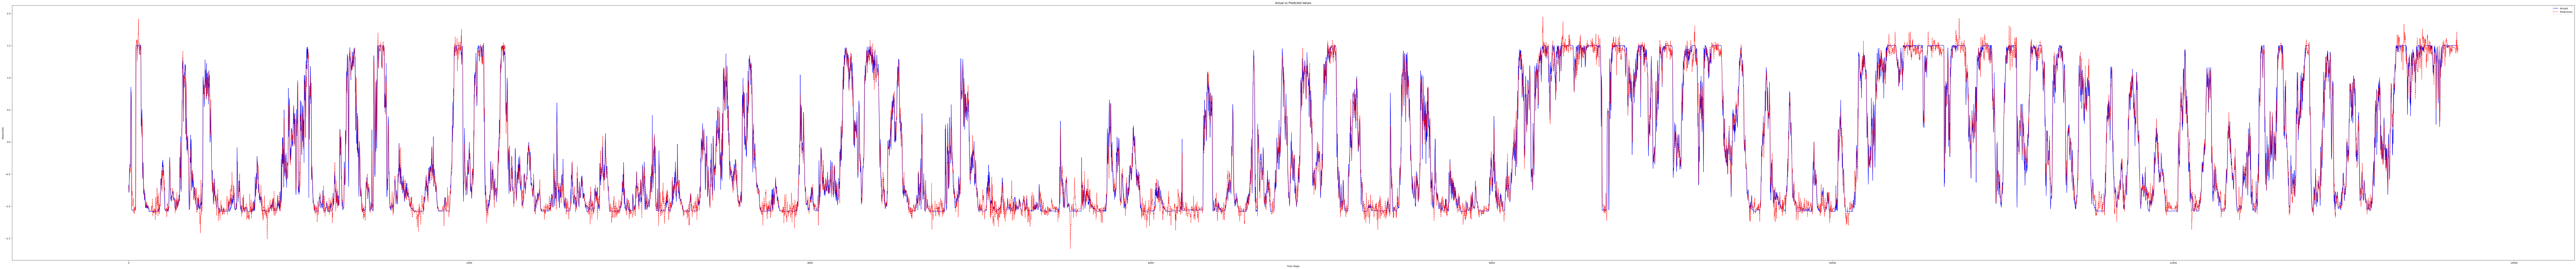

In [79]:
import matplotlib.pyplot as plt

y_pred = model.forward(x_test.to('cpu') )

# get y_test to device
y_test = torch.tensor(y_test).float().to(device)
y_pred = torch.tensor(y_pred).float().to(device)
# get the loss on the test dataset
testCriterion = nn.MSELoss()

print(f"y_pred shape: {y_pred.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_pred type: {type(y_pred)}")
print(f"y_test type: {type(y_test)}")
loss = testCriterion(y_pred, y_test)
print(f"Loss on the test dataset: {loss.item()}")

all_actuals = y_test.cpu().detach().numpy()
all_predictions = y_pred.cpu().detach().numpy()

# Plotting
plt.figure(figsize=(200, 20))
plt.plot(all_actuals, label='Actuals', color='blue')
plt.plot(all_predictions, label='Predictions', color='red', linestyle='dashed')
plt.title(f'Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Power(kW)')
plt.legend()
plt.show()

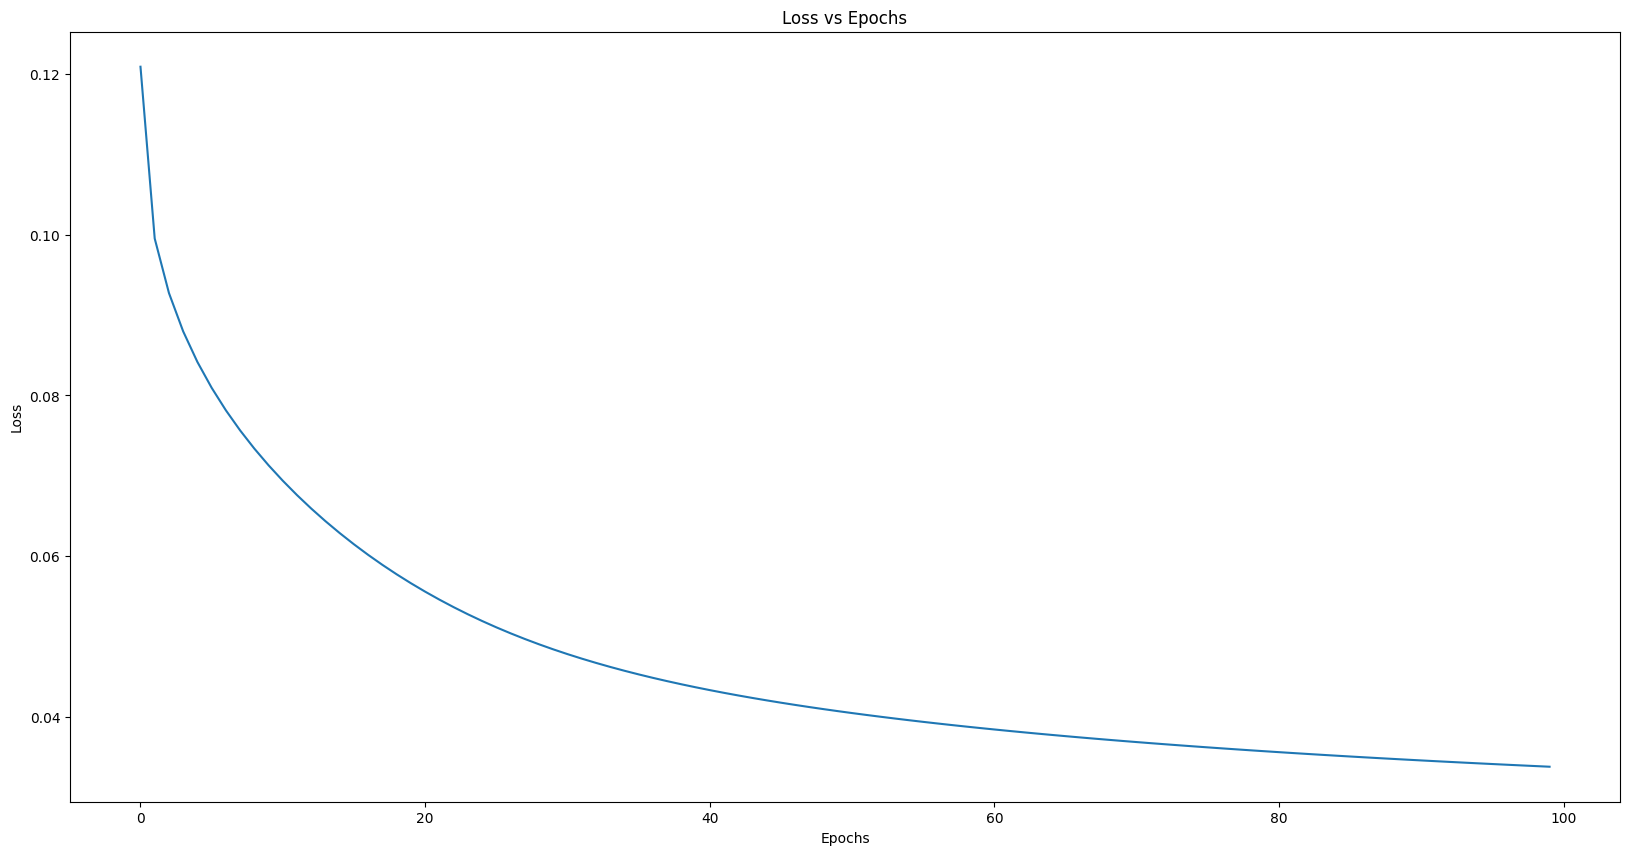

In [80]:
# print the loss vs epochs graph
costval = [c.cpu().detach().numpy() for c in costval]

plt.figure(figsize=(20, 10))
plt.plot(costval)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [81]:
y_pred = model(x_test.to('cpu') )

y_test = y_test.to('cpu')

y_pred = y_pred.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()

In [82]:
# get the mean average error

y_pred = model(x_test.to('cpu') )

y_test = torch.tensor(y_test).float().to(device)

print(f"y_pred type: {type(y_pred)}")
print(f"y_test type: {type(y_test)}")

ara = y_pred.to(device)
y_pred = ara

y_test = y_test.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()

mae = np.mean(np.abs(y_test - y_pred))

# get the mse
mean_mse = np.mean(np.square(y_test - y_pred))

print(f"Mean Square Error (MSE) on the test set: {mean_mse}")

print(f"Mean absolute error (MAE) on the test set: {mae}")

y_pred type: <class 'torch.Tensor'>
y_test type: <class 'torch.Tensor'>
Mean Square Error (MSE) on the test set: 0.03650835156440735
Mean absolute error (MAE) on the test set: 0.12954175472259521
